In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from imblearn.over_sampling import SMOTENC
from matplotlib.lines import Line2D

In [2]:
data=pd.read_csv('student_performance_large_dataset_new.csv')
data.head()

,Unnamed: 0,Student_ID,Age,Gender,Study_Hours_per_Week,Preferred_Learning_Style,Online_Courses_Completed,Participation_in_Discussions,Assignment_Completion_Rate....,Exam_Score....,Attendance_Rate....,Use_of_Educational_Tech,Self_Reported_Stress_Level,Time_Spent_on_Social_Media..hours.week.,Sleep_Hours_per_Night,Final_Grade
0,1,S00001,18,Female,48,Kinesthetic,14,Yes,100,85.964060,66,Yes,High,9,8,A
1,2,S00002,29,Female,30,Reading/Writing,20,No,71,81.584196,57,Yes,Medium,28,8,B
2,3,S00003,20,Female,47,Kinesthetic,11,No,60,84.828407,79,Yes,Low,13,7,B
3,4,S00004,23,Female,13,Auditory,0,Yes,63,57.502203,60,Yes,Low,24,10,C
4,5,S00005,19,Female,24,Auditory,19,Yes,59,74.638949,93,Yes,Medium,26,8,B


In [3]:
data.columns = data.columns.str.replace(r'\.*$', '', regex=True)
cleaned_data=data.drop(columns=['Student_ID','Unnamed: 0','Final_Grade','Exam_Score'],errors='ignore')
grade_mapping = {"A": 0, "B": 1, "C": 2, "D": 3}
data['Final_Grade_Encoded'] = data['Final_Grade'].map(grade_mapping)


In [4]:
categorical_cols = [
    'Gender',
    'Participation_in_Discussions',
    'Use_of_Educational_Tech',
    'Preferred_Learning_Style',
    'Self_Reported_Stress_Level'
]

for col in categorical_cols:
    dummies = pd.get_dummies(cleaned_data[col], prefix=col, drop_first=True)
    cleaned_data = pd.concat([cleaned_data.drop(col, axis=1), dummies], axis=1)


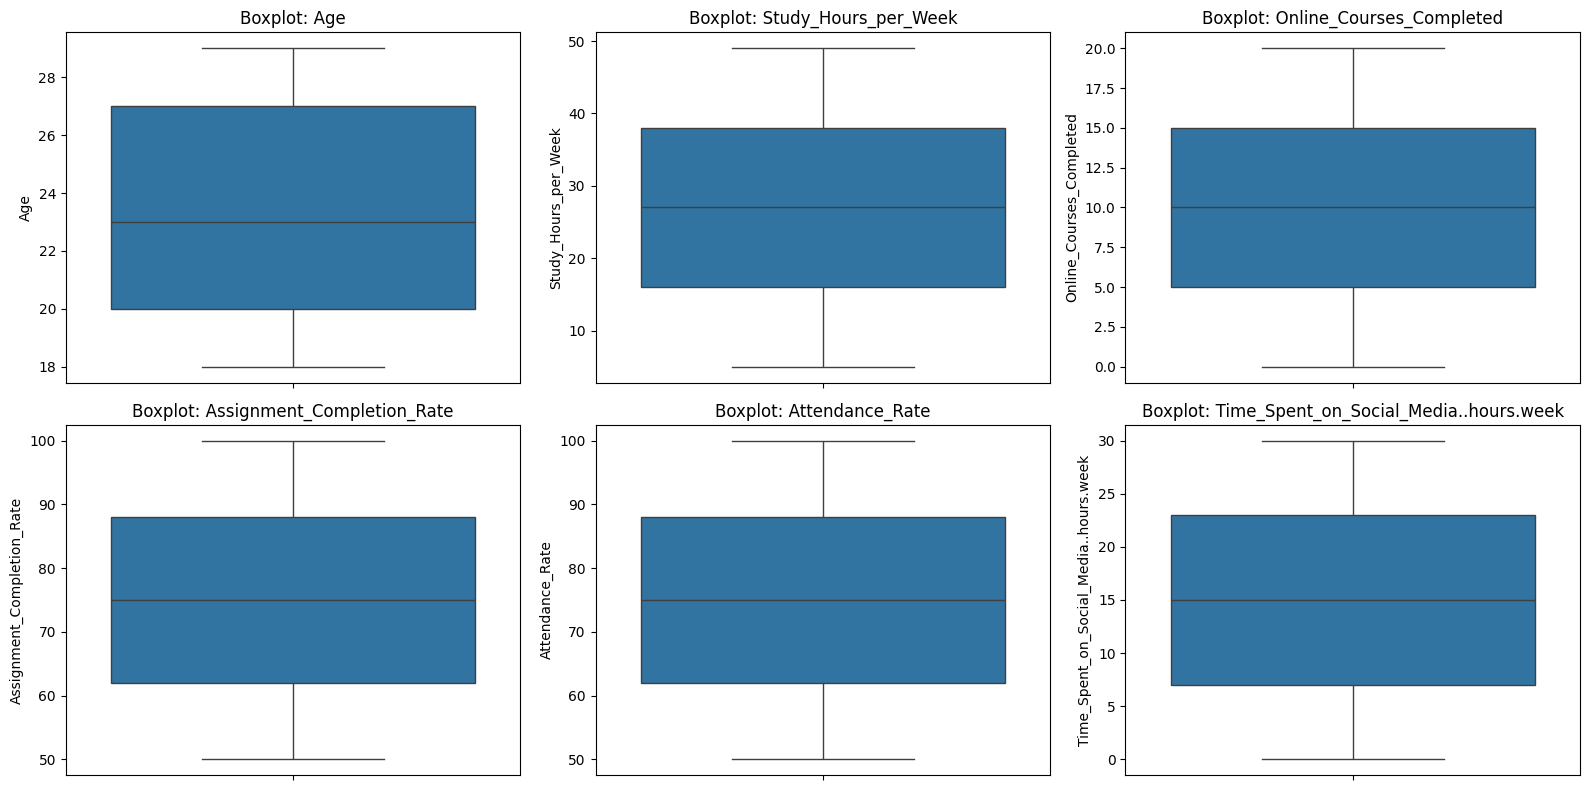

In [5]:
# Example for all numeric features
numeric_cols = cleaned_data.select_dtypes(include=np.number).columns

plt.figure(figsize=(16, 8))
for i, col in enumerate(numeric_cols[:6], 1):  # adjust number of plots shown
    plt.subplot(2, 3, i)
    sns.boxplot(y=cleaned_data[col])
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

In [6]:
# Step 1: Drop one-hot/dummy columns
# Example for all numeric features
numeric_cols = cleaned_data.select_dtypes(include=np.number).columns


clustering_input = cleaned_data[numeric_cols].copy()
print(clustering_input.columns)

Index(['Age', 'Study_Hours_per_Week', 'Online_Courses_Completed',
       'Assignment_Completion_Rate', 'Attendance_Rate',
       'Time_Spent_on_Social_Media..hours.week', 'Sleep_Hours_per_Night'],
      dtype='object')


In [7]:
# scale data
clustering_input_scaled = StandardScaler().fit_transform(clustering_input)
# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(clustering_input_scaled)

In [8]:
# Build a summary DataFrame
summary_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(pca.explained_variance_))],
    'Standard Deviation': np.sqrt(pca.explained_variance_),
    'Proportion of Variance': pca.explained_variance_ratio_,
    'Cumulative Proportion': np.cumsum(pca.explained_variance_ratio_)
})

print(summary_df)


loadings = pd.DataFrame(
    pca.components_.T,  # transpose so features are rows
    columns=[f'PC{i+1}' for i in range(7)],
    index=clustering_input.columns
)

loadings.head(10)

    PC  Standard Deviation  Proportion of Variance  Cumulative Proportion
0  PC1            1.015489                0.147302               0.147302
1  PC2            1.014643                0.147057               0.294359
2  PC3            1.004686                0.144185               0.438544
3  PC4            1.001071                0.143149               0.581693
4  PC5            0.993559                0.141009               0.722701
5  PC6            0.989005                0.139719               0.862420
6  PC7            0.981404                0.137580               1.000000


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
Age,0.553241,0.162327,-0.182275,-0.363191,0.264878,0.633036,0.177615
Study_Hours_per_Week,-0.263661,0.654650,0.090888,-0.234560,0.103623,-0.257878,0.601164
Online_Courses_Completed,-0.379361,0.522825,-0.266162,-0.003856,-0.371124,0.403017,-0.460136
Assignment_Completion_Rate,0.067318,0.159151,0.617329,0.612359,-0.086467,0.411412,0.193195
Attendance_Rate,-0.521172,-0.119330,0.274746,-0.173412,0.707954,0.233873,-0.229538
Time_Spent_on_Social_Media..hours.week,0.329706,0.432655,-0.204622,0.446605,0.497366,-0.313994,-0.341778
Sleep_Hours_per_Night,0.309247,0.212080,0.623877,-0.456669,-0.159124,-0.218616,-0.434172


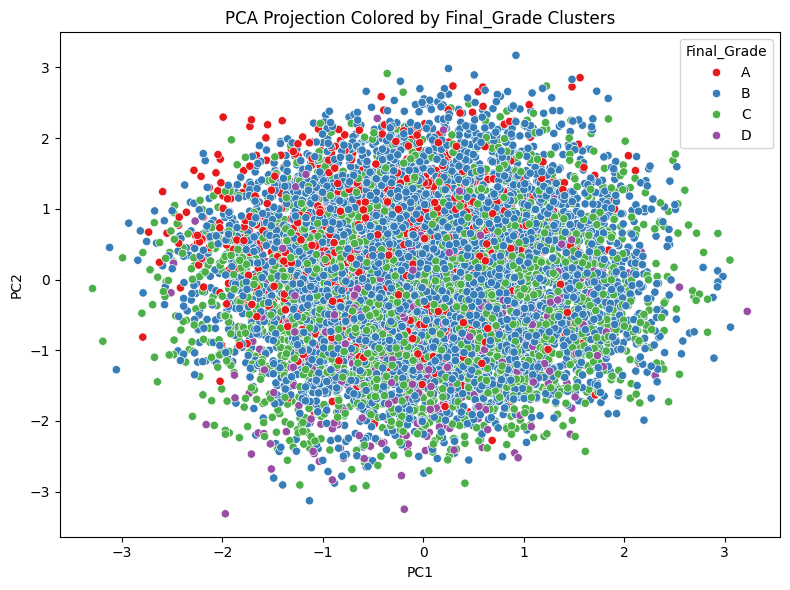

In [9]:
#Visualize Clusters in PCA Space coloerd by final Grade label 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1],hue=data['Final_Grade'], palette='Set1')
plt.title("PCA Projection Colored by Final_Grade Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

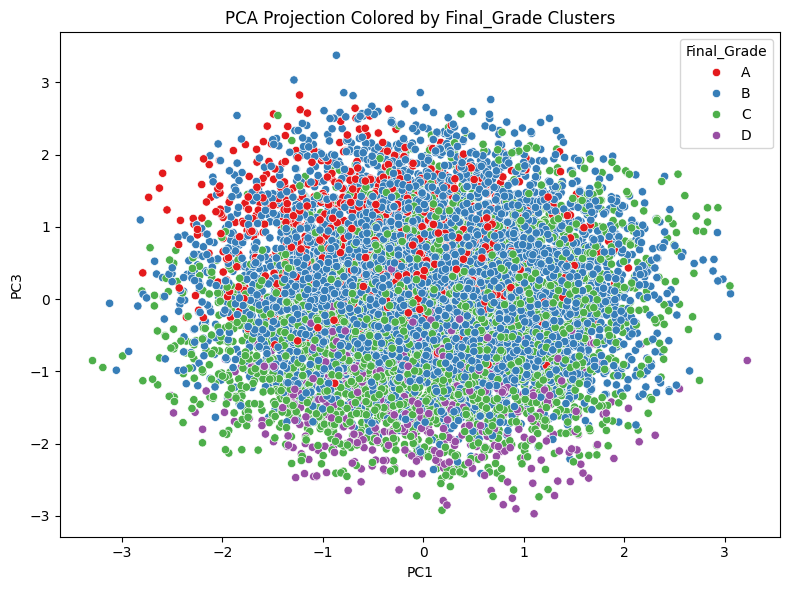

In [10]:
#Visualize Clusters in PCA Space coloerd by final Grade label 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 2],hue=data['Final_Grade'], palette='Set1')
plt.title("PCA Projection Colored by Final_Grade Clusters")
plt.xlabel("PC1")
plt.ylabel("PC3")
plt.tight_layout()
plt.show()

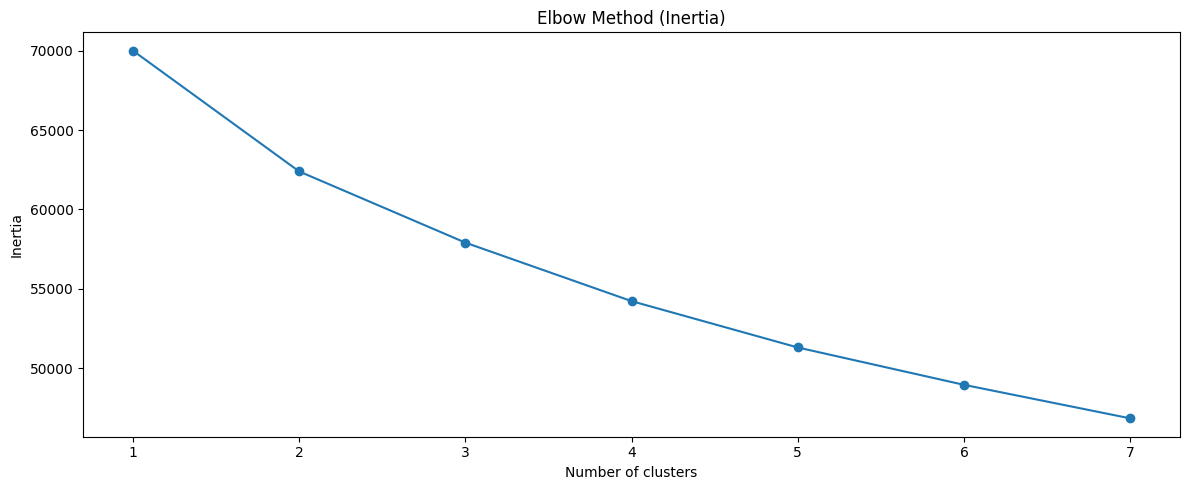

In [11]:
# Evaluate KMeans for a range of cluster numbers
inertia = []
k_range = range(1, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_pca)
    inertia.append(kmeans.inertia_)
    

# Plot elbow method and silhouette scores
plt.figure(figsize=(12, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()


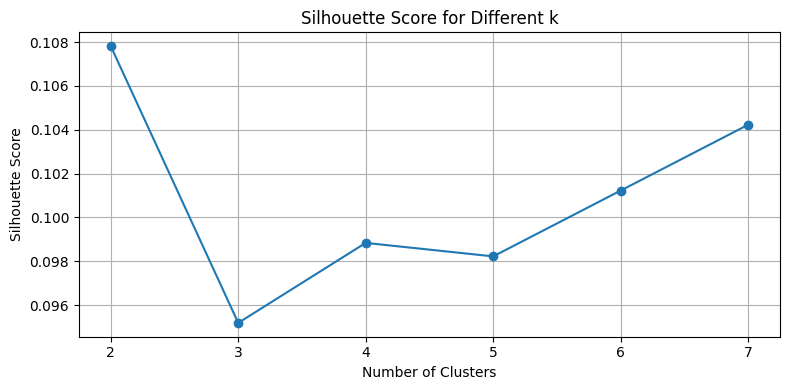

In [12]:
silhouette_scores = []
k_range = range(2, 8)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_pca)
    score = silhouette_score(data_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
# Apply KMeans with the optimal number of clusters (k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(data_pca)

# Add the cluster labels and Final_Grade back to the DataFrame
data['KMeans_Cluster_pca'] = kmeans_labels

# Show distribution of Final Grades across clusters
kmeans_cluster_grade_crosstab = pd.crosstab(data['KMeans_Cluster_pca'], data['Final_Grade'], normalize='index')
kmeans_cluster_grade_crosstab


Final_Grade,A,B,C,D
KMeans_Cluster_pca,,,,
0,0.047276,0.573718,0.324519,0.054487
1,0.107565,0.614657,0.251773,0.026005
2,0.186651,0.603118,0.199041,0.011191
3,0.023539,0.510146,0.377435,0.088880


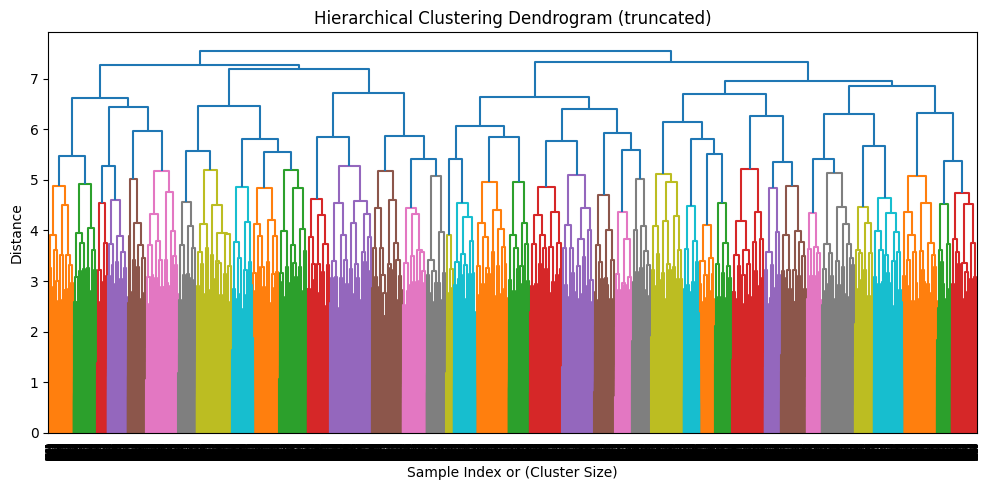

In [14]:
# Plot dendrogram
linked = linkage(data_pca, method='complete')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [15]:
# Fit Agglomerative Clustering with 4 clusters (based on dendrogram or silhouette score)
hc_model = AgglomerativeClustering(n_clusters=4, linkage='complete')
hc_labels = hc_model.fit_predict(data_pca)

# Assign cluster labels to original data
data['HC_Cluster_pca'] = hc_labels

# Compare with final grades
h_cluster_grade_crosstab =pd.crosstab(data['HC_Cluster_pca'], data['Final_Grade'], normalize='index')
h_cluster_grade_crosstab

Final_Grade,A,B,C,D
HC_Cluster_pca,,,,
0,0.057539,0.529289,0.348700,0.064471
1,0.112949,0.633771,0.233314,0.019966
2,0.099683,0.496149,0.333031,0.071137
3,0.095578,0.651926,0.226819,0.025678


In [16]:

# Show distribution of Final Grades across clusters
kmeans_cluster_grade_crosstab = pd.crosstab(data['KMeans_Cluster_pca'], data['HC_Cluster_pca'], normalize='index')
kmeans_cluster_grade_crosstab

HC_Cluster_pca,0,1,2,3
KMeans_Cluster_pca,,,,
0,0.288061,0.339744,0.285657,0.086538
1,0.412136,0.207644,0.069346,0.310875
2,0.250200,0.331735,0.323741,0.094325
3,0.200487,0.528003,0.206169,0.065341


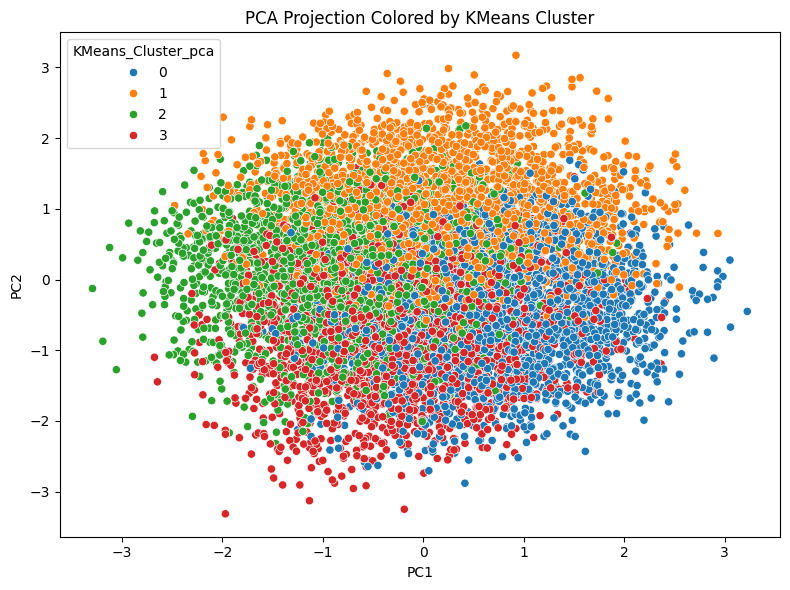

In [17]:
#Visualize Clusters in PCA Space coloerd by k mean cluster

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1],hue=data['KMeans_Cluster_pca'], palette='tab10')
plt.title("PCA Projection Colored by KMeans Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

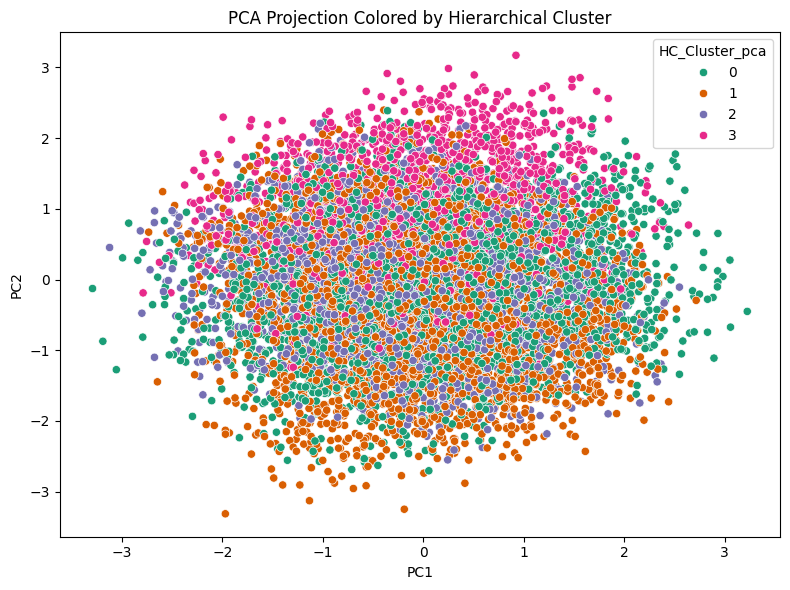

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=data['HC_Cluster_pca'], palette='Dark2')
plt.title("PCA Projection Colored by Hierarchical Cluster")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()


In [19]:
data.columns = data.columns.str.replace(r'\.*$', '', regex=True)
fs_cleaned_data=data.drop(columns=['Student_ID','Unnamed: 0','Exam_Score','HC_Cluster_pca','KMeans_Cluster_pca','Final_Grade_Encoded'],errors='ignore')
grade_mapping = {"A": 0, "B": 1, "C": 2, "D": 3}



In [20]:
# Step 3: Identify numerical columns (excluding target)
numeric_cols = fs_cleaned_data.select_dtypes(include=['number']).columns

# Step 4: Scale only numeric columns
scaler = StandardScaler()
fs_cleaned_data[numeric_cols] = scaler.fit_transform(fs_cleaned_data[numeric_cols])

In [21]:
# Create an ordinal encoding for Final_Grade
grade_mapping = {"A": 1, "B": 2, "C": 3, "D": 4}
fs_cleaned_data["Final_Grade"] = fs_cleaned_data["Final_Grade"].map(grade_mapping)

categorical_cols = [
    'Gender',
    'Participation_in_Discussions',
    'Use_of_Educational_Tech',
    'Preferred_Learning_Style',
    'Self_Reported_Stress_Level'
]

for col in categorical_cols:
    dummies = pd.get_dummies(fs_cleaned_data[col], prefix=col, drop_first=True)
    fs_cleaned_data = pd.concat([fs_cleaned_data.drop(col, axis=1), dummies], axis=1)

fs_cleaned_data.head()

,Age,Study_Hours_per_Week,Online_Courses_Completed,Assignment_Completion_Rate,Attendance_Rate,Time_Spent_on_Social_Media..hours.week,Sleep_Hours_per_Night,Final_Grade,Gender_Male,Gender_Other,Participation_in_Discussions_Yes,Use_of_Educational_Tech_Yes,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium
0,-1.582639,1.605127,0.650559,1.708927,-0.616001,-0.657989,0.511151,1,False,False,True,True,True,False,False,False,False
1,1.594887,0.220714,1.628328,-0.267263,-1.226232,1.447930,0.511151,2,False,False,False,True,False,True,False,False,True
2,-1.004907,1.528215,0.161674,-1.016852,0.265444,-0.214638,0.010366,2,False,False,False,True,True,False,False,True,False
3,-0.138309,-1.086788,-1.630902,-0.812418,-1.022822,1.004579,1.512721,3,False,False,True,True,False,False,False,True,False
4,-1.293773,-0.240757,1.465366,-1.084996,1.214692,1.226255,0.511151,2,False,False,True,True,False,False,False,False,True


In [22]:
X= fs_cleaned_data.drop(['Final_Grade'], axis=1)
y = fs_cleaned_data["Final_Grade"]
# Step 2: Identify categorical feature indices (after one-hot encoding, binary columns)
categorical_feature_mask = X.nunique() == 2  # One-hot columns
categorical_indices = [i for i, is_cat in enumerate(categorical_feature_mask) if is_cat]

# Step 3: Apply SMOTENC
smoter = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_bal, y_bal = smoter.fit_resample(X, y)

X_bal_df = pd.DataFrame(X_bal, columns=X.columns)
y_bal_df = pd.Series(y_bal, name="Final_Grade")

# If needed: combined into one DataFrame
fs_cleaned_data = pd.concat([X_bal_df, y_bal_df], axis=1)

In [23]:
fs_cleaned_data.head()

,Age,Study_Hours_per_Week,Online_Courses_Completed,Assignment_Completion_Rate,Attendance_Rate,Time_Spent_on_Social_Media..hours.week,Sleep_Hours_per_Night,Gender_Male,Gender_Other,Participation_in_Discussions_Yes,Use_of_Educational_Tech_Yes,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium,Final_Grade
0,-1.582639,1.605127,0.650559,1.708927,-0.616001,-0.657989,0.511151,False,False,True,True,True,False,False,False,False,1
1,1.594887,0.220714,1.628328,-0.267263,-1.226232,1.447930,0.511151,False,False,False,True,False,True,False,False,True,2
2,-1.004907,1.528215,0.161674,-1.016852,0.265444,-0.214638,0.010366,False,False,False,True,True,False,False,True,False,2
3,-0.138309,-1.086788,-1.630902,-0.812418,-1.022822,1.004579,1.512721,False,False,True,True,False,False,False,True,False,3
4,-1.293773,-0.240757,1.465366,-1.084996,1.214692,1.226255,0.511151,False,False,True,True,False,False,False,False,True,2


In [24]:

X,y=fs_cleaned_data.drop(columns=['Final_Grade']),fs_cleaned_data['Final_Grade']
X = X.astype(float)
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2,shuffle=True,random_state=42)
# Check the shapes
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
X_train.head()

Training set size: (18425, 16)
Test set size: (4607, 16)


,Age,Study_Hours_per_Week,Online_Courses_Completed,Assignment_Completion_Rate,Attendance_Rate,Time_Spent_on_Social_Media..hours.week,Sleep_Hours_per_Night,Gender_Male,Gender_Other,Participation_in_Discussions_Yes,Use_of_Educational_Tech_Yes,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium
7241,-1.582639,-0.548405,-1.142018,0.141604,0.197640,-1.544692,1.512721,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1071,1.594887,-1.548259,1.139443,0.277893,-0.751608,-1.433854,-0.991204,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
7502,-1.582639,1.374392,-1.630902,-1.289430,-0.955018,-0.768827,1.011936,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
5305,1.594887,1.066744,-0.979056,-0.130974,-0.412591,0.228714,-0.991204,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
19031,-1.518364,0.853024,1.592067,0.792811,-1.474816,0.339694,-1.491988,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:

# 1. Define model
rf = RandomForestClassifier(random_state=42)

# 2.  parameter space
param_dist = {
    'n_estimators': randint(100, 200),       
    'max_depth': [None, 10, 20],             
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt'],                 
    'bootstrap': [True]                   
}

# 3. Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

# 4. Random search with fewer iterations
search = RandomizedSearchCV(rf, param_distributions=param_dist,
                            n_iter=20, cv=cv, n_jobs=-1, random_state=42)
search.fit(X_train, y_train)

# 5. Best parameters
print("Best Parameters:", search.best_params_)


Best Parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


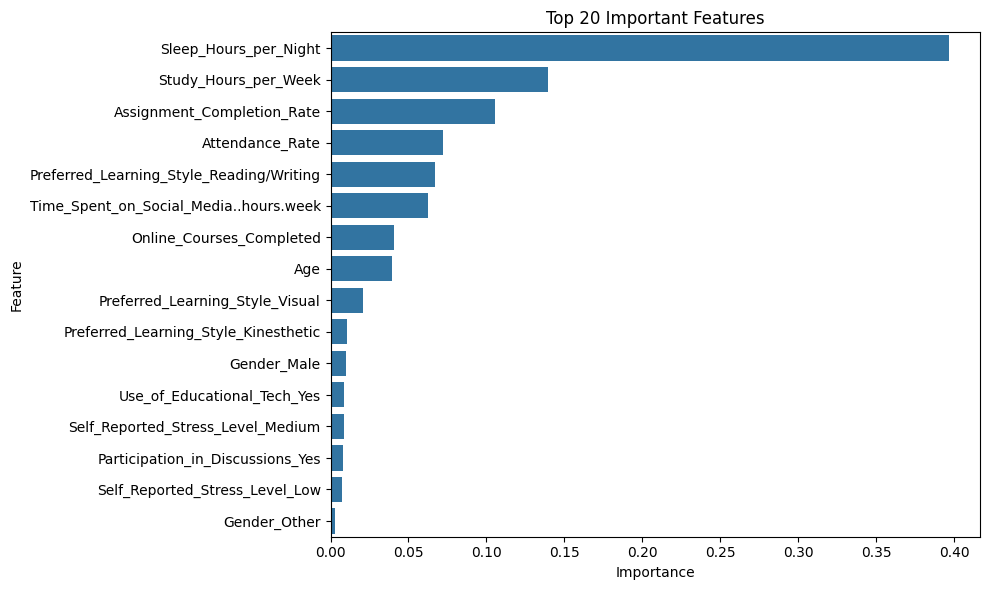

,Feature,Importance
6,Sleep_Hours_per_Night,0.396855
1,Study_Hours_per_Week,0.139704
3,Assignment_Completion_Rate,0.105531
4,Attendance_Rate,0.072474
12,Preferred_Learning_Style_Reading/Writing,0.066969
5,Time_Spent_on_Social_Media..hours.week,0.062415
2,Online_Courses_Completed,0.040455
0,Age,0.039299
13,Preferred_Learning_Style_Visual,0.020783
11,Preferred_Learning_Style_Kinesthetic,0.010596


In [26]:
# Get feature importances
best_randomForestModel = search.best_estimator_
importances = best_randomForestModel.feature_importances_
feature_names = X.columns
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()
feat_df.head(20)

In [27]:
feature_importance_threshold = 0.01

# 1. Select features with importance above threshold
important_features = feat_df[feat_df.Importance > feature_importance_threshold]['Feature'].tolist()
print(important_features)


['Sleep_Hours_per_Night', 'Study_Hours_per_Week', 'Assignment_Completion_Rate', 'Attendance_Rate', 'Preferred_Learning_Style_Reading/Writing', 'Time_Spent_on_Social_Media..hours.week', 'Online_Courses_Completed', 'Age', 'Preferred_Learning_Style_Visual', 'Preferred_Learning_Style_Kinesthetic']


In [28]:
# Create an ordinal encoding for Final_Grade
X_data=data.copy()


categorical_cols = [
    'Gender',
    'Participation_in_Discussions',
    'Use_of_Educational_Tech',
    'Preferred_Learning_Style',
    'Self_Reported_Stress_Level'
]

for col in categorical_cols:
    dummies = pd.get_dummies(X_data[col], prefix=col, drop_first=True)
    X_data = pd.concat([X_data.drop(col, axis=1), dummies], axis=1)

X_data.head()


,Unnamed: 0,Student_ID,Age,Study_Hours_per_Week,Online_Courses_Completed,Assignment_Completion_Rate,Exam_Score,Attendance_Rate,Time_Spent_on_Social_Media..hours.week,Sleep_Hours_per_Night,...,HC_Cluster_pca,Gender_Male,Gender_Other,Participation_in_Discussions_Yes,Use_of_Educational_Tech_Yes,Preferred_Learning_Style_Kinesthetic,Preferred_Learning_Style_Reading/Writing,Preferred_Learning_Style_Visual,Self_Reported_Stress_Level_Low,Self_Reported_Stress_Level_Medium
0,1,S00001,18,48,14,100,85.964060,66,9,8,...,2,False,False,True,True,True,False,False,False,False
1,2,S00002,29,30,20,71,81.584196,57,28,8,...,3,False,False,False,True,False,True,False,False,True
2,3,S00003,20,47,11,60,84.828407,79,13,7,...,1,False,False,False,True,True,False,False,True,False
3,4,S00004,23,13,0,63,57.502203,60,24,10,...,1,False,False,True,True,False,False,False,True,False
4,5,S00005,19,24,19,59,74.638949,93,26,8,...,3,False,False,True,True,False,False,False,False,True


In [29]:
imp_X_data=X_data[important_features].copy()
imp_X_data.head()
# Step 3: Identify numerical columns (excluding target)
numeric_cols = imp_X_data.select_dtypes(include=['number']).columns

# Step 4: Scale only numeric columns
scaler = StandardScaler()
imp_X_data[numeric_cols] = scaler.fit_transform(imp_X_data[numeric_cols])

In [30]:
imp_X_data = imp_X_data.astype(int)
imp_X_data.head()

,Sleep_Hours_per_Night,Study_Hours_per_Week,Assignment_Completion_Rate,Attendance_Rate,Preferred_Learning_Style_Reading/Writing,Time_Spent_on_Social_Media..hours.week,Online_Courses_Completed,Age,Preferred_Learning_Style_Visual,Preferred_Learning_Style_Kinesthetic
0,0,1,1,0,0,0,0,-1,0,1
1,0,0,0,-1,1,1,1,1,0,0
2,0,1,-1,0,0,0,0,-1,0,1
3,1,-1,0,-1,0,1,-1,0,0,0
4,0,0,-1,1,0,1,1,-1,0,0


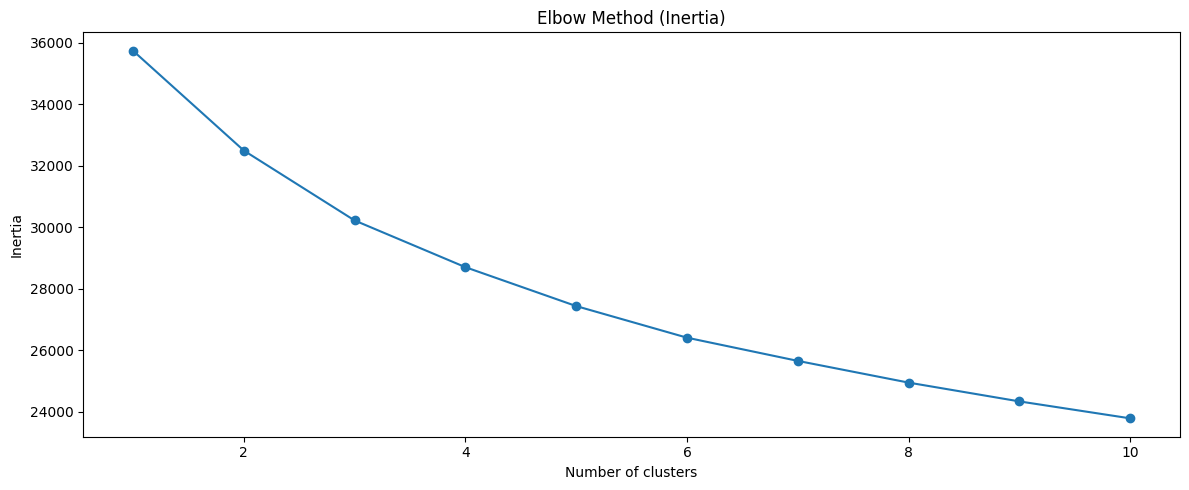

In [31]:
# Evaluate KMeans for a range of cluster numbers
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(imp_X_data)
    inertia.append(kmeans.inertia_)
    

# Plot elbow method and silhouette scores
plt.figure(figsize=(12, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method (Inertia)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()


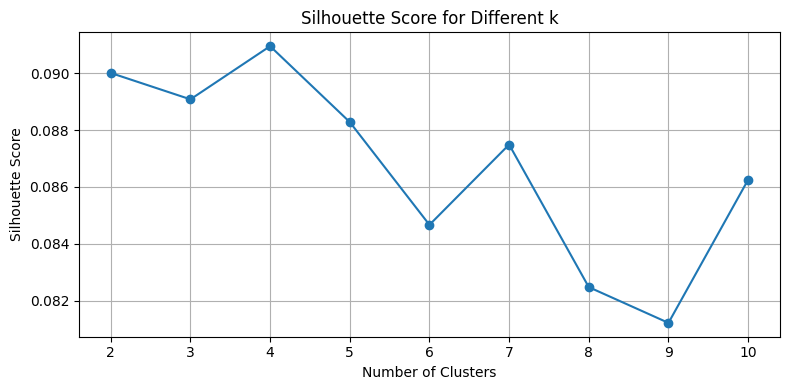

In [32]:
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(imp_X_data)
    score = silhouette_score(imp_X_data, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title("Silhouette Score for Different k")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# Apply KMeans with the optimal number of clusters (k=4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(imp_X_data)

# Add the cluster labels and Final_Grade back to the DataFrame
X_data['KMeans_Cluster'] = kmeans_labels

# Show distribution of Final Grades across clusters
kmeans_cluster_grade_crosstab = pd.crosstab(X_data['KMeans_Cluster'], X_data['Final_Grade'], normalize='index')
kmeans_cluster_grade_crosstab


Final_Grade,A,B,C,D
KMeans_Cluster,,,,
0,0.076803,0.595226,0.290088,0.037883
1,0.084582,0.618415,0.263896,0.033108
2,0.195705,0.574427,0.216203,0.013665
3,0.009014,0.463945,0.415164,0.111877


In [34]:
# Select top N important features (e.g., top 6) based on Random Forest

# Calculate cluster-wise average for top features
KM_cluster_means = X_data.groupby('KMeans_Cluster')[important_features].mean()

# Normalize for radar plot
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
KM_cluster_means_normalized = pd.DataFrame(scaler.fit_transform(KM_cluster_means), 
                                        columns=important_features, 
                                        index=KM_cluster_means.index)


In [35]:
def plot_radar_with_feature_legend(
    data, feature_labels, cluster_labels, name_map=None, n_rows=2, n_cols=2, fontsize=10
):
    num_clusters = len(cluster_labels)
    num_features = len(feature_labels)

    # Use numbers around the radar chart instead of full feature names
    numbered_labels = [f"{i+1}" for i in range(num_features)]
    feature_legend_labels = [f"{i+1}: {label}" for i, label in enumerate(feature_labels)]

    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    angles += angles[:1]

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), subplot_kw=dict(polar=True))
    axs = axs.flatten()

    color_map = plt.get_cmap('tab10')

    for i, idx in enumerate(cluster_labels):
        ax = axs[i]
        values = data.loc[idx].tolist() + [data.loc[idx].tolist()[0]]
        label_name = name_map[idx] if name_map else f"Cluster {idx}"
        color = color_map(i % 10)

        ax.plot(angles, values, linewidth=2, color=color, label=label_name)
        ax.fill(angles, values, alpha=0.25, color=color)

        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)

        ax.set_thetagrids(np.degrees(angles[:-1]), numbered_labels, fontsize=fontsize)
        ax.set_yticks([0.25, 0.5, 0.75, 1.0])
        ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], fontsize=fontsize - 1)
        ax.set_title(f"{label_name}", fontsize=fontsize + 2, pad=20)

    # Turn off unused subplots if needed
    for j in range(len(cluster_labels), len(axs)):
        fig.delaxes(axs[j])

    # Create fake handles to represent feature names
    fake_handles = [Line2D([0], [0], color='black', linewidth=0) for _ in feature_labels]

    # Add custom legend with feature names (numbered)
    fig.legend(
        handles=fake_handles,
        labels=feature_legend_labels,
        loc='lower center',
        ncol=min(4, len(feature_labels)),
        fontsize=fontsize - 1,
        title="Feature Index Map",
        title_fontsize=fontsize,
        frameon=True,
        bbox_to_anchor=(0.5, -0.05)
    )

    plt.tight_layout()
    plt.show()


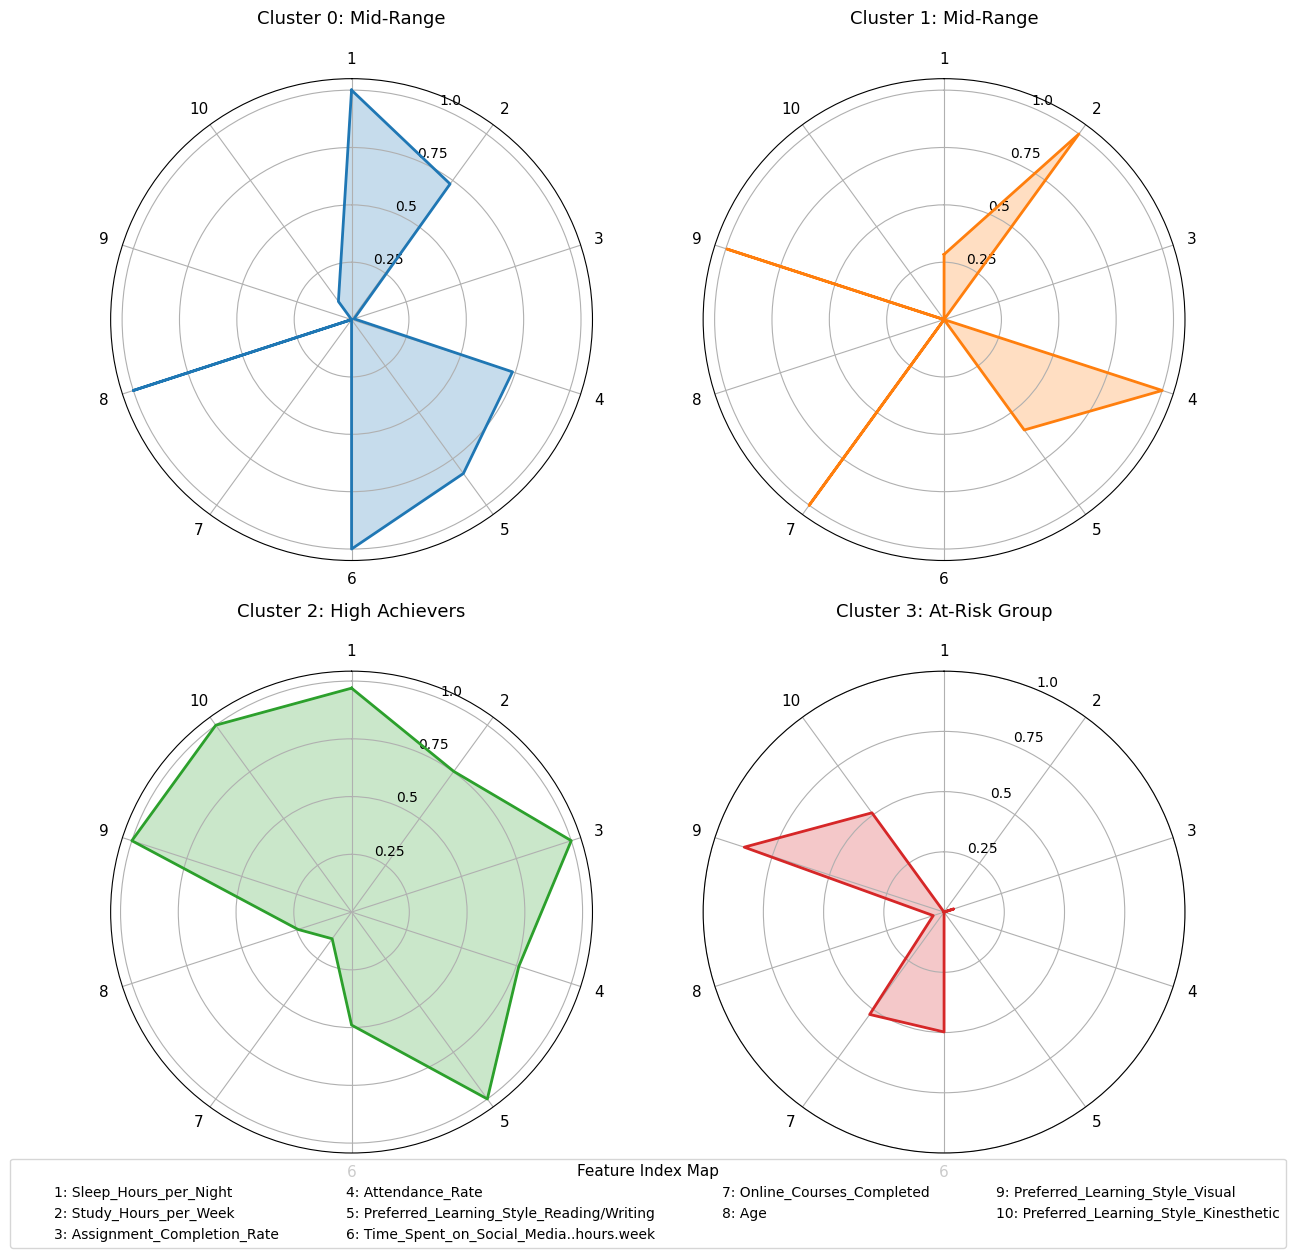

In [36]:
# Optional: Customize names for clusters
KM_named_clusters = {
    0: "Cluster 0: Mid-Range",
    1: "Cluster 1: Mid-Range",
    2: "Cluster 2: High Achievers",
    3: "Cluster 3: At-Risk Group"
}

# Plot radar charts
plot_radar_with_feature_legend(
    data=KM_cluster_means_normalized,
    feature_labels=important_features,
    cluster_labels=KM_cluster_means_normalized.index,
    name_map=KM_named_clusters,
    n_rows=2,
    n_cols=2,
    fontsize=11
)


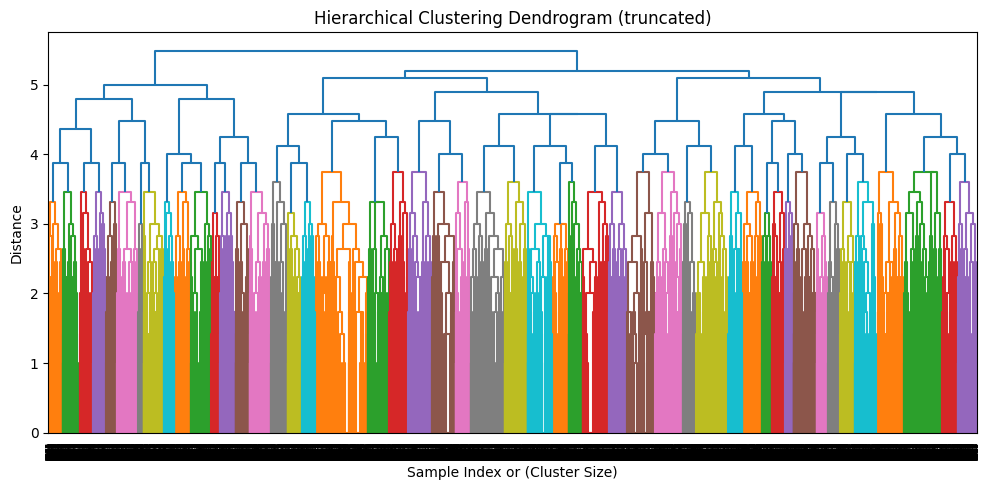

In [37]:
# Plot dendrogram
linked = linkage(imp_X_data, method='complete')
plt.figure(figsize=(10, 5))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Sample Index or (Cluster Size)')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [38]:
# Fit Agglomerative Clustering with 4 clusters (based on dendrogram or silhouette score)
hc_model = AgglomerativeClustering(n_clusters=4, linkage='complete')
hc_labels = hc_model.fit_predict(imp_X_data)

# Assign cluster labels to original data
X_data['HC_Cluster'] = hc_labels

# Compare with final grades
h_cluster_grade_crosstab =pd.crosstab(X_data['HC_Cluster'], X_data['Final_Grade'], normalize='index')
h_cluster_grade_crosstab

Final_Grade,A,B,C,D
HC_Cluster,,,,
0,0.104879,0.619619,0.259588,0.015914
1,0.071309,0.528357,0.325688,0.074646
2,0.094100,0.521285,0.319268,0.065347
3,0.083410,0.659945,0.225481,0.031164


In [39]:
# Select top N important features (e.g., top 6) based on Random Forest

# Calculate cluster-wise average for top features
H_cluster_means = X_data.groupby('HC_Cluster')[important_features].mean()

# Normalize for radar plot
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
H_cluster_means_normalized = pd.DataFrame(scaler.fit_transform(H_cluster_means), 
                                        columns=important_features, 
                                        index=H_cluster_means.index)


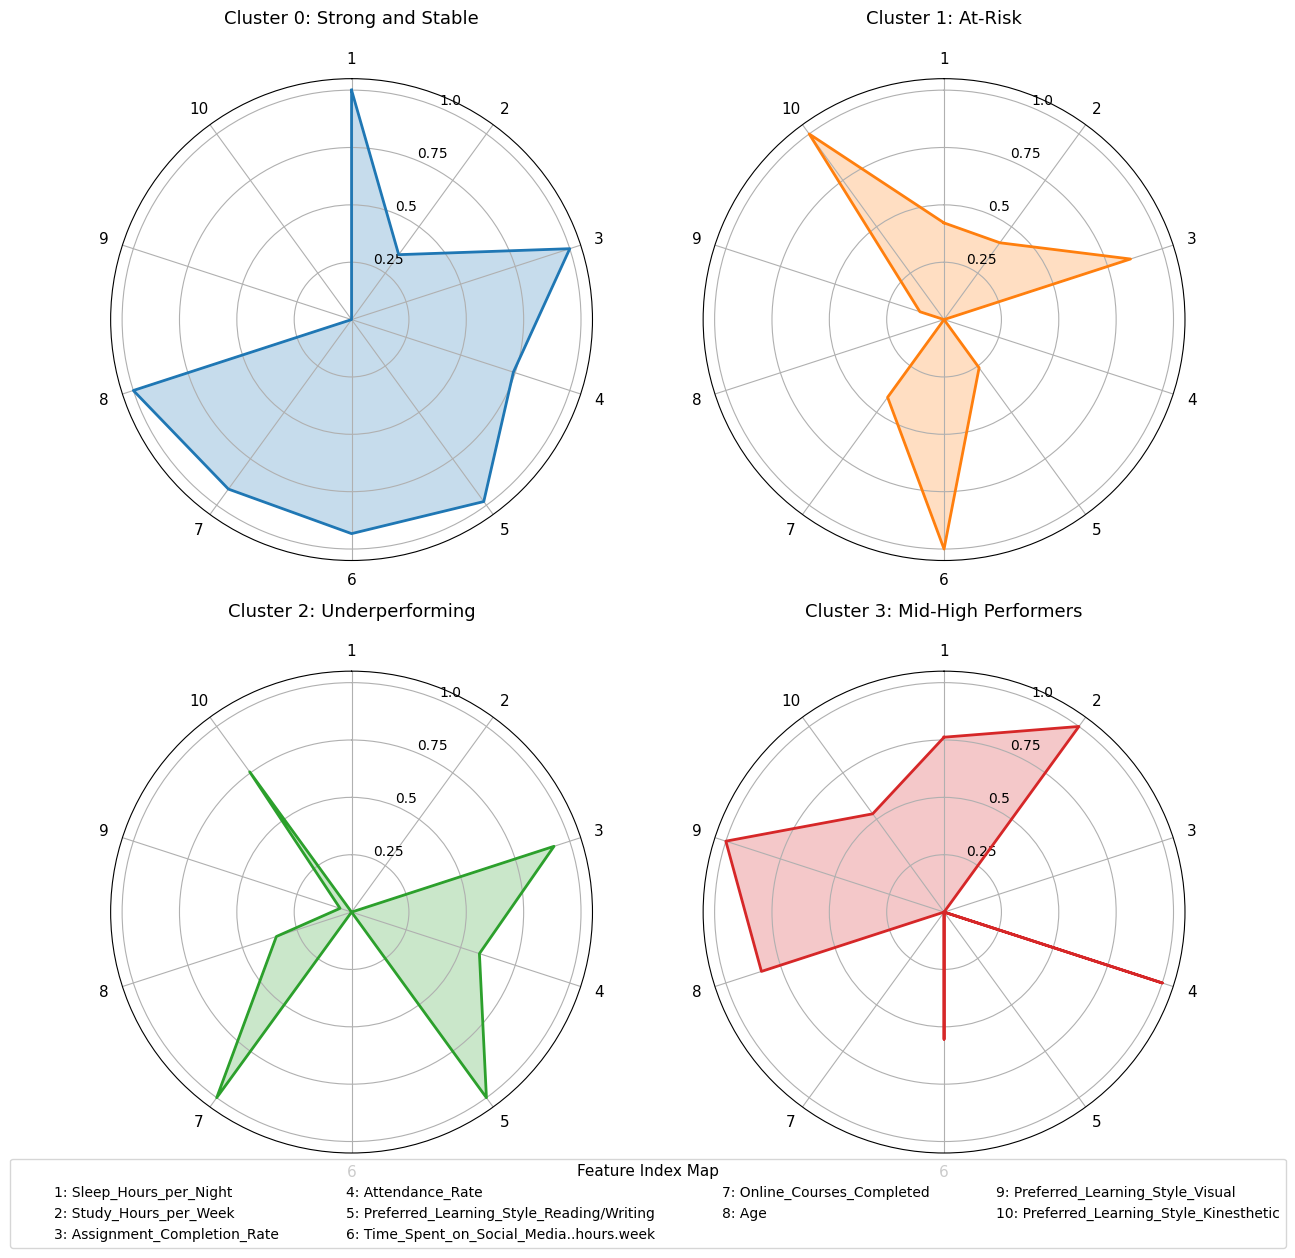

In [40]:
H_named_clusters = {
    0: "Cluster 0: Strong and Stable",
    1: "Cluster 1: At-Risk",
    2: "Cluster 2: Underperforming",
    3: "Cluster 3: Mid-High Performers"
}



# Plot radar charts
plot_radar_with_feature_legend(
    data=H_cluster_means_normalized,
    feature_labels=important_features,
    cluster_labels=H_cluster_means_normalized.index,
    name_map=H_named_clusters,
    n_rows=2,
    n_cols=2,
    fontsize=11
)


In [41]:

# Show distribution of Final Grades across clusters
kmeans_cluster_grade_crosstab = pd.crosstab(X_data['KMeans_Cluster'], X_data['HC_Cluster'], normalize='index')
kmeans_cluster_grade_crosstab

HC_Cluster,0,1,2,3
KMeans_Cluster,,,,
0,0.542294,0.067981,0.236118,0.153607
1,0.318028,0.256887,0.246738,0.178347
2,0.440215,0.239141,0.318692,0.001952
3,0.302227,0.378579,0.291092,0.028102
